In [2]:
import pandas as pd
import numpy as np
from pydeseq2.preprocessing import deseq2_norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from matplotlib.gridspec import GridSpec
from scipy.io import mmread
from scipy.stats import kendalltau
import os

In [3]:
def TPM_function(bambu_rpk):
    
    summation = sum(bambu_rpk)
    
    if summation > 0: 
        bambu_ScaleFactor = sum(bambu_rpk) / 1e6
        bambu_tpm = bambu_rpk / bambu_ScaleFactor
        return bambu_tpm
    else:
        return bambu_rpk

In [7]:
def spearman_count(short_read_path, short_read_infRV, quant_dir, short_read_flag, majorTxp, file_type, compare_type, mean_val):
    
    #dataset
    directRNA_txp = 'Hct116_31'  
    d = {'Hct116_32': 'directcDNA', 'Hct116_31': 'directRNA'} 
    
    # read ground truth
    if short_read_flag:
        t = pd.read_csv(short_read_path, sep="\t")
        t.columns = t.columns.str.upper()
        t.rename(columns={t.columns[3]: "SHORT_READ"}, inplace=True)
        
        #======================================================================================================
        #read in all synthetic transcripts in Hct116 dataset
        synthetic = pd.read_csv("/fs/cbcb-scratch/zzare/exp_quant/Hct116_quant/synthetic_txp_names.csv", sep="\t", header=None)
        synthetic.columns = ["NAME"]
        #======================================================================================================
        
        #choose the transcripts with the lower infRV values (threshold valus is the mean(infRVs))
        infRV = pd.read_csv(short_read_infRV, sep="\t")
        #-----------------------------------------------------------
        #infRV_synthetic = infRV[infRV["Txp"].isin(synthetic["NAME"])]
        #-----------------------------------------------------------
        infRV = infRV[~infRV["Txp"].isin(synthetic["NAME"])]
        
        if mean_val == "nonZero_mean":
            infRV = infRV[infRV["mean"] != 0]

        if compare_type == "0.1":
            mean_value = 0.1
        elif compare_type == "0.5":
            mean_value = 0.5
        elif compare_type == "all":
            mean_value = max(infRV["infRV"])
        infRV_txps = infRV[infRV["infRV"] <= mean_value]
        
        #-----------------------------------------------------------
        #infRV_txps = pd.concat([infRV_txps, infRV_synthetic], axis=0)
        #-----------------------------------------------------------
        t = pd.merge(infRV_txps, t, left_on="Txp", right_on="NAME", how="left")

        print("is there nan value in NAME: ", t['NAME'].isna().any())
        
        t.replace(np.nan, 0, inplace=True)
        t['SHORT_READ'] = TPM_function(t['SHORT_READ'])

        how_value = "right"
    else:
        t = pd.read_excel(short_read_path, sheet_name="Sheet1")
        t = t.iloc[1:, 0:2]
        t.columns = ["NAME", "SHORT_READ"]
        t["SHORT_READ"] = pd.to_numeric(t["SHORT_READ"], errors='coerce')
        
        t.replace(np.nan, 0, inplace=True)
        t['SHORT_READ'] = TPM_function(t['SHORT_READ'])
        
        how_value = "right"
    
    
        
    #read major transcripts
    if majorTxp:
        #read major transcripts file
        t_major = pd.read_excel("/fs/cbcb-scratch/zzare/exp_quant/Hct116_quant/media-3.xlsx", sheet_name="SummaryWithinCellLine")
        t_major = t_major[t_major['cellLine'] == directRNA_txp.split('_')[0]]
        unique_gene_txp_pairs = set(zip(t_major['gene_name'], t_major['txMajor']))
        unique_gene_txp_df = pd.DataFrame(list(unique_gene_txp_pairs), columns=['GENEID', 'TXNAME'])


    #read in the count files   
    oarfish_align_cov = {k: {} for k in d}
    oarfish_align_nocov = {k: {} for k in d}
    NanoCount = {k: {} for k in d}
    bambu = {k: {} for k in d}
    kallisto = {k: {} for k in d}
    isoquant = {k: {} for k in d}
    espresso = {k: {} for k in d}
    transigner = {k: {} for k in d}
    
    for k, v in d.items():
        if file_type == "No_shr":
            oarfish_align_cov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant/{v}/{k}/out_cov.quant", sep="\t")
            oarfish_align_nocov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant/{v}/{k}/out_nocov.quant", sep="\t")
            ##########################################################################################
        elif file_type == "shr":
            oarfish_align_cov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant_ShR/{v}/{k}/out_cov.quant", sep="\t")
            oarfish_align_nocov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant_ShR/{v}/{k}/out_nocov.quant", sep="\t")
            ##########################################################################################
        ##########################################################################################
        NanoCount[v] = pd.read_csv(f"{quant_dir}/NanoCount_quant/{v}/{k}/isoform_expression_estimates", sep="\t")
        NanoCount[v].rename(columns={NanoCount[v].columns[2]: "num_reads"}, inplace=True)
        NanoCount[v]['transcript_name'] = NanoCount[v]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount[v] = NanoCount[v].groupby(NanoCount[v]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        bambu[v] = pd.read_csv(f"{quant_dir}/bambu_quant/{v}/{k}/counts_transcript.txt", sep="\t")
        bambu[v].rename(columns={bambu[v].columns[2]: "num_reads"}, inplace=True)
        bambu[v]['TXNAME'] = bambu[v]['TXNAME'].apply(lambda x: x.split('.')[0])
        bambu[v] = bambu[v].groupby(bambu[v]['TXNAME'])['num_reads'].sum().reset_index()
        ###########################################################################################
        kallisto[v] = pd.read_csv(f'{quant_dir}/lr-kallisto/{v}/{k}/bus_quant_tcc.tsv', sep='\t')
        kallisto[v].rename(columns={kallisto[v].columns[1]: "num_reads"}, inplace=True)
        kallisto[v]['transcript_id'] = kallisto[v]['transcript_id'].apply(lambda x: x.split('.')[0])
        kallisto[v] = kallisto[v].groupby(kallisto[v]['transcript_id'])['num_reads'].sum().reset_index()
        ###########################################################################################
        espresso[v] = pd.read_csv(f"{quant_dir}/espresso_quant/{v}/{k}/sam_sorted_N2_R0_abundance.esp", sep="\t")
        espresso[v].rename(columns={espresso[v].columns[3]: "num_reads"}, inplace=True)
        espresso[v]['transcript_ID'] = espresso[v]['transcript_ID'].apply(lambda x: x.split('.')[0])
        espresso[v] = espresso[v].groupby(espresso[v]['transcript_ID'])['num_reads'].sum().reset_index()
        ###########################################################################################
        transigner[v] = pd.read_csv(f"{quant_dir}/transigner_quant/{v}/{k}/abundances.tsv", sep="\t", header=None)
        transigner[v].columns = ['Txp', 'abundance', 'num_reads']
        transigner[v].rename(columns={transigner[v].columns[2]: "num_reads"}, inplace=True)
        transigner[v]['Txp'] = transigner[v]['Txp'].apply(lambda x: x.split('.')[0])
        transigner[v] = transigner[v].groupby(transigner[v]['Txp'])['num_reads'].sum().reset_index()
        ###########################################################################################
        isoquant[v] = pd.read_csv(f"{quant_dir}/IsoQuant_quant/{v}/{k}/OUT/OUT.transcript_counts.tsv", sep="\t")
        isoquant[v]['#feature_id'] = isoquant[v]['#feature_id'].str.split('.').str[0]
        isoquant[v].rename(columns={isoquant[v].columns[1]: "num_reads"}, inplace=True)
        isoquant[v] = isoquant[v].groupby(isoquant[v]['#feature_id'])['num_reads'].sum().reset_index()
        
    
    #obtain the TPM of the counts

    for k, v in d.items():
        oarfish_align_cov[v]['num_reads'] = TPM_function(oarfish_align_cov[v]['num_reads'])
        oarfish_align_nocov[v]['num_reads'] = TPM_function(oarfish_align_nocov[v]['num_reads'])
        NanoCount[v]['num_reads'] = TPM_function(NanoCount[v]['num_reads'])
        bambu[v]['num_reads'] = TPM_function(bambu[v]['num_reads'])
        kallisto[v]['num_reads'] = TPM_function(kallisto[v]['num_reads'])
        isoquant[v]['num_reads'] = TPM_function(isoquant[v]['num_reads'])
        espresso[v]['num_reads'] = TPM_function(espresso[v]['num_reads'])
        transigner[v]['num_reads'] = TPM_function(transigner[v]['num_reads'])   

    m = {}
    for k, v in d.items():
        #print(v)
        m[v] = pd.merge(oarfish_align_cov[v], t, left_on="tname", right_on="NAME", how="right", suffixes=('_align_cov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (cov)"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(oarfish_align_nocov[v], m[v], left_on="tname", right_on="NAME", how="right", suffixes=('_align_nocov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (nocov)"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(NanoCount[v], m[v], left_on="transcript_name", right_on="NAME", how="right", suffixes=('_NanoCount', ''))
        m[v] = m[v].rename(columns={"num_reads" : "NanoCount"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(bambu[v], m[v], left_on="TXNAME", right_on="NAME", how="right", suffixes=('_bambu', ''))
        m[v] = m[v].rename(columns={"num_reads" : "bambu"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(kallisto[v], m[v], left_on="transcript_id", right_on="NAME", how="right", suffixes=('_kallisto', ''))
        m[v] = m[v].rename(columns={"num_reads" : "lr-kallisto"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(espresso[v], m[v], left_on="transcript_ID", right_on="NAME", how="right", suffixes=('_espresso', ''))
        m[v] = m[v].rename(columns={"num_reads" : "ESPRESSO"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(transigner[v], m[v], left_on="Txp", right_on="NAME", how="right", suffixes=('_transigner', ''))
        m[v] = m[v].rename(columns={"num_reads" : "TranSigner"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(isoquant[v], m[v], left_on="#feature_id", right_on="NAME", how="right", suffixes=('_isoquant', ''))
        m[v] = m[v].rename(columns={"num_reads" : "IsoQuant"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        
        if majorTxp:
            m[v] = pd.merge(unique_gene_txp_df, m[v], left_on="TXNAME", right_on="NAME", how="inner")
        m[v] = m[v].fillna(0)
    
    for v in d.values():
        for j in ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "SHORT_READ"]:
            m[v][j] = TPM_function(m[v][j])
    
    columns_to_compare = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO"]
    epsilon = 1e-10
    
    output = {'spearman': {}, 'pearson': {}, 'CCC': {}, 'Kendall': {}, 'RMSE': {}, 'NRMSE': {}, 'MARD': {}}
    for method in output.keys():
        tmp = {}
        for k, v in m.items():
            mix = "SHORT_READ"
            if method == "spearman":
                tmp[k] = v.loc[:, ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "SHORT_READ"]].corr(method="spearman")[mix]
                tmp[k] = tmp[k][:-1]
            #---------------------------------------------------------------------------------------
            if method == "pearson":
                pseudocount = 1.0
                log2_columns = v.loc[:, ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "SHORT_READ"]].apply(lambda x: np.log2(x + pseudocount))
                tmp[k] = log2_columns.corr(method="pearson")[mix]
                tmp[k] = tmp[k][:-1]
            #---------------------------------------------------------------------------------------
            if method == "Kendall":
                Kendall_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    tau, p_value = kendalltau(y_true, y_pred)
                    Kendall_values[column_name] = tau
                tmp[k] = pd.Series(Kendall_values)
            #---------------------------------------------------------------------------------------
            if method == "CCC":
                pseudocount = 1.0
                log2_columns = v.loc[:, ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "SHORT_READ"]].apply(lambda x: np.log2(x + pseudocount))
                pearson_corr = log2_columns.corr(method="pearson")[mix]
                
                ccc_correlation = {}
                for column_name in columns_to_compare:
                    y_true = log2_columns[mix]
                    y_pred = log2_columns[column_name]
                    #obtain the mean value
                    mean_true = np.mean(y_true)
                    mean_pred = np.mean(y_pred)
                    #obtain the standard deviation
                    std_true = np.std(y_true)
                    std_pred = np.std(y_pred)
                    ccc_correlation[column_name] = (2 * pearson_corr[column_name] * std_true * std_pred) / \
                                                   (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
                tmp[k] = pd.Series(ccc_correlation)
            #---------------------------------------------------------------------------------------
            if method == "RMSE":
                rmse_values = {}
                nrmse_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    rmse_values[column_name] = rmse
                tmp[k] = pd.Series(rmse_values)
            #---------------------------------------------------------------------------------------
            if method == "NRMSE":
                nrmse_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    range_observed = np.mean(y_true)
                    nrmse_values[column_name] = rmse / range_observed
                tmp[k] = pd.Series(nrmse_values)
            #---------------------------------------------------------------------------------------
            if method == "MARD":
                mard_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    filtered_y_pred = y_pred
                    filtered_y_true = y_true
                    mard = np.mean(abs((filtered_y_pred - filtered_y_true) / (filtered_y_pred + filtered_y_true + epsilon)))
                    mard_values[column_name] = mard
                tmp[k] = pd.Series(mard_values)
            #---------------------------------------------------------------------------------------

            #---------------------------------------------------------------------------------------
        output[method] = pd.DataFrame(tmp)
        #output[method] = output[method].reset_index().rename(columns={'index': 'Method'})
    
    return output

    

In [8]:
def plot_function(tmp_list, fig_path):

    input_list = {}
    for k, v in tmp_list.items():
        input_list[k] = v.reset_index().rename(columns={'index': 'Method'})
        
    fig = plt.figure(figsize=(12, 12))  # Increased figure width to accommodate legend
    gs = GridSpec(5, 3, width_ratios=[1, 1, 0.5])  # Add an extra column for the legend

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    ax7 = fig.add_subplot(gs[3, 0])
    ax8 = fig.add_subplot(gs[3, 1])
    ax9 = fig.add_subplot(gs[4, 0])
    ax10 = fig.add_subplot(gs[4, 1])
    #ax11 = fig.add_subplot(gs[5, 0])
    #ax12 = fig.add_subplot(gs[5, 1])
    ax_legend = fig.add_subplot(gs[:, 2])  # This will be the space for the legend
    ax_legend.axis('off')  # Turn off the axis for the legend

    #color_palette = sns.color_palette("dark", 12)
    color_palette = plt.get_cmap("tab10").colors[:8]
    marker_palette = ['s', '^', 'o', 'p', 'h', '+', 'x', '*', 'd', 'v', '>', '<', 'o']


    cl = 0
    ml = 0
    
    # For collecting legend handles and labels
    handles = []
    labels = []
    
    v1 = "directcDNA"
    v2 = "directRNA"
    
    method_list = list(input_list['spearman']['Method'])
    
    for method in method_list:
        
        # Plot spearman vs pearson
        h1, = ax1.plot(input_list['pearson'][v1][input_list['pearson']['Method'] == method], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax2.plot(input_list['pearson'][v2][input_list['pearson']['Method'] == method], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs CCC
        ax3.plot(input_list['CCC'][v1][input_list['CCC']['Method'] == method], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax4.plot(input_list['CCC'][v2][input_list['CCC']['Method'] == method], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs Kendall
        ax5.plot(input_list['Kendall'][v1][input_list['Kendall']['Method'] == method], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax6.plot(input_list['Kendall'][v2][input_list['Kendall']['Method'] == method], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot Spearman vs 1/RMSE
        #ax7.plot([1/x for x in input_list['RMSE'][v1][input_list['RMSE']['Method']==method]], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        #ax8.plot([1/x for x in input_list['RMSE'][v2][input_list['RMSE']['Method']==method]], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs 1/NRMSE
        ax7.plot([1/x for x in input_list['NRMSE'][v1][input_list['NRMSE']['Method'] == method]], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax8.plot([1/x for x in input_list['NRMSE'][v2][input_list['NRMSE']['Method'] == method]], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs 1/MARD
        ax9.plot([1/x for x in input_list['MARD'][v1][input_list['MARD']['Method'] == method]], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax10.plot([1/x for x in input_list['MARD'][v2][input_list['MARD']['Method'] == method]], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        handles.extend([h1])
        labels.extend([f"{method}"])
        
        cl += 1
        ml += 1
    
    
    
    v1 = "ONT (direct-cDNA)"
    v2 = "ONT (direct-RNA)"
    # Set labels and titles for each subplot
    ax1.set_xlabel('Pearson (log(1 + x)) ', fontsize=10)
    ax1.set_ylabel('Spearman ρ', fontsize=10)
    ax1.set_title(f'{v1}', fontsize=10)
    ax1.grid(True)  # Add grid lines
    ax1.text(0.0, 1.05, 'a)', transform=ax1.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax2.set_xlabel('Pearson (log(1 + x)) ', fontsize=10)
    ax2.set_ylabel('Spearman ρ', fontsize=10)
    ax2.set_title(f'{v2}', fontsize=10)
    ax2.grid(True)  # Add grid lines
    ax2.text(0.0, 1.05, 'b)', transform=ax2.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    ax3.set_xlabel('CCC', fontsize=10)
    ax3.set_ylabel('Spearman ρ', fontsize=10)
    ax3.set_title(f'{v1}', fontsize=10)
    ax3.grid(True)  # Add grid lines
    ax3.text(0.0, 1.05, 'c)', transform=ax3.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax4.set_xlabel('CCC', fontsize=10)
    ax4.set_ylabel('Spearman ρ', fontsize=10)
    ax4.set_title(f'{v2}', fontsize=10)
    ax4.grid(True)  # Add grid lines
    ax4.text(0.0, 1.05, 'd)', transform=ax4.transAxes, ha="left", va="center", fontsize=12, weight="bold")

    #=======================================================================================================
    
    ax5.set_xlabel('Kendall-τ', fontsize=10)
    ax5.set_ylabel('Spearman ρ', fontsize=10)
    ax5.set_title(f'{v1}', fontsize=10)
    ax5.grid(True)  # Add grid lines
    ax5.text(0.0, 1.05, 'e)', transform=ax5.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax6.set_xlabel('Kendall-τ', fontsize=10)
    ax6.set_ylabel('Spearman ρ', fontsize=10)
    ax6.set_title(f'{v2}', fontsize=10)
    ax6.grid(True)  # Add grid lines
    ax6.text(0.0, 1.05, 'f)', transform=ax6.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    #ax7.set_xlabel('1/RMSE', fontsize=10)
    #ax7.set_ylabel('Spearman ρ', fontsize=10)
    #ax7.set_title(f'({v1})', fontsize=10)
    #ax7.grid(True)  # Add grid lines
    #ax7.text(0.0, 1.05, 'g)', transform=ax7.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    #
    #ax8.set_xlabel('1/RMSE', fontsize=10)
    #ax8.set_ylabel('Spearman ρ', fontsize=10)
    #ax8.set_title(f'({v2})', fontsize=10)
    #ax8.grid(True)  # Add grid lines
    #ax8.text(0.0, 1.05, 'h)', transform=ax8.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    ax7.set_xlabel('1/NRMSE', fontsize=10)
    ax7.set_ylabel('Spearman ρ', fontsize=10)
    ax7.set_title(f'{v1}', fontsize=10)
    ax7.grid(True)  # Add grid lines
    ax7.text(0.0, 1.05, 'g)', transform=ax7.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax8.set_xlabel('1/NRMSE', fontsize=10)
    ax8.set_ylabel('Spearman ρ', fontsize=10)
    ax8.set_title(f'{v2}', fontsize=10)
    ax8.grid(True)  # Add grid lines
    ax8.text(0.0, 1.05, 'h)', transform=ax8.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    ax9.set_xlabel('1/MARD', fontsize=10)
    ax9.set_ylabel('Spearman ρ', fontsize=10)
    ax9.set_title(f'{v1}', fontsize=10)
    ax9.grid(True)  # Add grid lines
    ax9.text(0.0, 1.05, 'i)', transform=ax9.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax10.set_xlabel('1/MARD', fontsize=10)
    ax10.set_ylabel('Spearman ρ', fontsize=10)
    ax10.set_title(f'{v2}', fontsize=10)
    ax10.grid(True)  # Add grid lines
    ax10.text(0.0, 1.05, 'j)', transform=ax10.transAxes, ha="left", va="center", fontsize=12, weight="bold")


    
    # Tight layout and legend adjustment
    plt.tight_layout()
    ax_legend.legend(handles=handles, labels=labels, loc='center', fontsize=10)

    # Save the figure as a JPEG file
    directory = os.path.dirname(fig_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


In [9]:
short_read_path = '/mnt/scratch2/zahra/exp_quant_time/Hct116_quant/RNAsequins_MixA.xlsx'
short_read_flag = False
majorTxp = False
experimental_data_path = '/mnt/scratch2/zahra/exp_quant_time/Hct116_quant'
file_path_count = {'No_shr': experimental_data_path, 
                   'shr': experimental_data_path} 

In [10]:
result = {}

for k, v in file_path_count.items():
    result[k] = {}
    result[k] = spearman_count(short_read_path, short_read_path, v, short_read_flag, majorTxp, k, "NONE", "NONE")

In [12]:
combined_df = pd.concat(result['No_shr'].values(), axis=1, keys=result['No_shr'].keys())
combined_df = combined_df.round(2)
combined_df = combined_df.reset_index().rename(columns={'index': 'Method'})
combined_df = combined_df.reset_index(drop=True)
combined_df

Method   spearman              pearson                  CCC  \
                   directcDNA directRNA directcDNA directRNA directcDNA   
0    oarfish (cov)       0.92      0.62       0.96      0.70       0.94   
1  oarfish (nocov)       0.92      0.62       0.96      0.70       0.94   
2        NanoCount       0.91      0.62       0.94      0.69       0.92   
3            bambu       0.92      0.60       0.95      0.66       0.93   
4      lr-kallisto       0.88      0.46       0.93      0.51       0.90   
5       TranSigner       0.90      0.61       0.95      0.69       0.93   
6         IsoQuant       0.89      0.60       0.93      0.67       0.92   
7         ESPRESSO       0.89      0.58       0.93      0.64       0.91   

               Kendall                 RMSE                NRMSE            \
  directRNA directcDNA directRNA directcDNA directRNA directcDNA directRNA   
0      0.56       0.81      0.52   10328.92  10014.90       1.69      1.64   
1      0.56       0.81      0.52   10316.47  10026.93       1.69      1.64   
2      0.56       0.80      0.52   16384.78  14091.06       2.69      2.31   
3      0.53       0.81      0.49   10417.71  22311.14       1.71      3.66   
4      0.37       0.76      0.38   11627.02  23986.10       1.91      3.93   
5      0.56       0.79      0.50   10337.42  10162.80       1.70      1.67   
6      0.53       0.78      0.50   11946.23  19082.30       1.96      3.13   
7      0.50       0.77      0.48   17610.95  20950.32       2.89      3.44   

        MARD            
  directcDNA directRNA  
0       0.62      0.87  
1       0.62      0.87  
2       0.65      0.87  
3       0.63      0.88  
4       0.66      0.93  
5       0.62      0.87  
6       0.62      0.88  
7       0.65      0.89

In [13]:
numeric_cols = combined_df.select_dtypes(include='number').columns
# Define the metric groups for correlation and error metrics
metric_groups = {
    'correlation': ['spearman', 'pearson', 'CCC', 'Kendall'],
    'error': ['RMSE', 'NRMSE', 'MARD']
}

correlation_columns = numeric_cols[numeric_cols.get_level_values(0).isin(metric_groups['correlation'])]
error_columns = numeric_cols[numeric_cols.get_level_values(0).isin(metric_groups['error'])]

max_values = combined_df[correlation_columns].max()
min_values = combined_df[error_columns].min()

# Apply the bold formatting for max/min values
def bold_max_min_values(val, metric, dataset):
    # Access max and min values for both metric and dataset using MultiIndex
    max_val = max_values.loc[(metric, dataset)] if (metric, dataset) in max_values.index else None
    min_val = min_values.loc[(metric, dataset)] if (metric, dataset) in min_values.index else None

    # Bold maximum values for correlation metrics
    if metric in metric_groups['correlation'] and val == max_val:
        return "\\textbf{" + f"{val:.2f}" + "}"
    # Bold minimum values for error metrics
    elif metric in metric_groups['error'] and val == min_val:
        return "\\textbf{" + f"{val:.2f}" + "}"
    
    return f"{val:.2f}"

#Apply formatting to each column
for metric, dataset in correlation_columns.union(error_columns):
    combined_df[(metric, dataset)] = combined_df[(metric, dataset)].apply(lambda x: bold_max_min_values(x, metric, dataset))

#Convert the updated DataFrame to LaTeX
latex_table = combined_df.to_latex(
    buf=None,
    column_format='lcccccccccccccc',  # Adjust according to the number of columns
    multirow=True,
    multicolumn=True,
    escape=False,  # Disable escaping so LaTeX formatting works
    caption="Metrics Comparison with Subdivisions",
    label="tab:metrics_comparison",
    index=False
)

#Print the LaTeX table
print(latex_table)

\begin{table}
\caption{Metrics Comparison with Subdivisions}
\label{tab:metrics_comparison}
\begin{tabular}{lcccccccccccccc}
\toprule
Method & \multicolumn{2}{r}{spearman} & \multicolumn{2}{r}{pearson} & \multicolumn{2}{r}{CCC} & \multicolumn{2}{r}{Kendall} & \multicolumn{2}{r}{RMSE} & \multicolumn{2}{r}{NRMSE} & \multicolumn{2}{r}{MARD} \\
 & directcDNA & directRNA & directcDNA & directRNA & directcDNA & directRNA & directcDNA & directRNA & directcDNA & directRNA & directcDNA & directRNA & directcDNA & directRNA \\
\midrule
oarfish (cov) & \textbf{0.92} & \textbf{0.62} & \textbf{0.96} & \textbf{0.70} & \textbf{0.94} & \textbf{0.56} & \textbf{0.81} & \textbf{0.52} & 10328.92 & \textbf{10014.90} & \textbf{1.69} & \textbf{1.64} & \textbf{0.62} & \textbf{0.87} \\
oarfish (nocov) & \textbf{0.92} & \textbf{0.62} & \textbf{0.96} & \textbf{0.70} & \textbf{0.94} & \textbf{0.56} & \textbf{0.81} & \textbf{0.52} & \textbf{10316.47} & 10026.93 & \textbf{1.69} & \textbf{1.64} & \textbf{0.62} & \tex

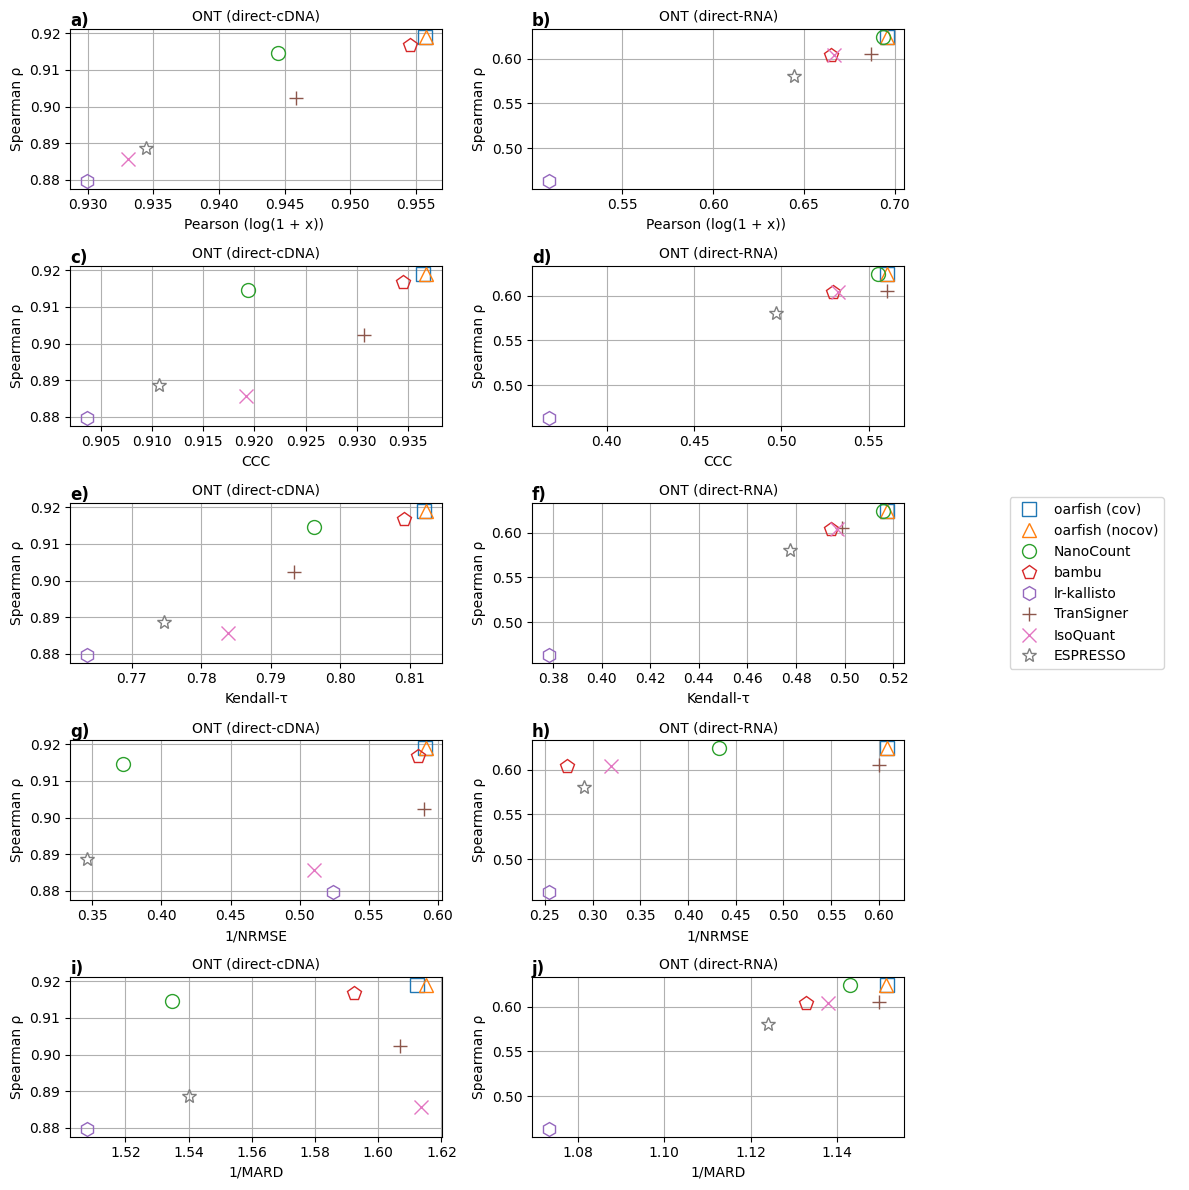

In [14]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/exp_data/hct116/sequinTxp/compare_metrics.jpg'
plot_function(result['No_shr'], fig_path)